我们将使用 Monte Carlo 方法，使用普通Python和numpy，对进程或线程池进行 $\pi$ 估计。这是一个简单的问题，具有很好的复杂性，因此很容易并行化；我们还可以看到将线程与numpy一起使用的意外结果。接下来，我们将使用相同的池方法搜索素数；我们将研究搜索素数的不可预测复杂性，并研究如何有效（和低效！）分配工作负载以最佳利用我们的计算资源。我们将通过切换到队列来完成素数搜索，在队列中引入 Process 对象来代替 Pool，并使用工作列表和 毒丸计划 (Poison Pills) 来控制工作站的生命周期。

接下来，我们将处理进程间通信（IPC），以验证一小部分可能的素数。通过将每个素数的工作负载拆分到多个CPU上，如果找到一个素数，我们就使用IPC提前结束搜索，这样我们就可以大大提高单CPU搜索进程的速度。我们将介绍共享的Python对象、OS原语和Redis服务器，以研究每种方法的复杂性和功能权衡。

我们可以在两个CPU上共享一个25GB numpy array，从而在不复制数据的情况下分割大量工作负载。如果有具有可并行化操作的大型 array，那么这种技术将为您带来极大的加速，因为您必须在RAM中分配更少的空间并复制更少的数据。最后，我们将研究在不损坏数据的情况下在进程之间同步对文件和变量（作为值）的访问，以说明如何正确锁定共享状态。

我们可以通过把成千上万个假想的飞镖扔进单位圆代表的“飞镖板”上来估计圆周率。落在圆边内的道数和落在圆边外的道数之间的关系，可以近似得到$\pi$。

这是一个理想问题，因为我们可以将整个工作负载平均地分配到多个进程上，每个进程都运行在一个单独的CPU上。每个进程都将在同一时间结束，因为每个进程的工作负载是相等的，因此我们可以研究在向问题中添加新CPU和超线程时可用的加速。

在下图中，我们把10000个飞镖扔进单位正方形，其中一个百分比落在所画单位圆的四分之一处。这个估计是相当糟糕的——10000掷镖不能可靠地给我们一个小数点后三位的结果。如果运行代码，会看到每次运行的估计值在3.0到3.2之间变化。

为了确定前三位小数点，我们需要生成10000000个随机掷镖。这是非常低效的（并且存在更好的 $\pi$ 估计方法），但是使用多处理来演示并行化的好处相当方便。

使用蒙特卡罗方法，我们使用毕达哥拉斯定理来测试飞镖是否落在我们的圆内：

$$x^2 + y^2\leq 1^2=1$$

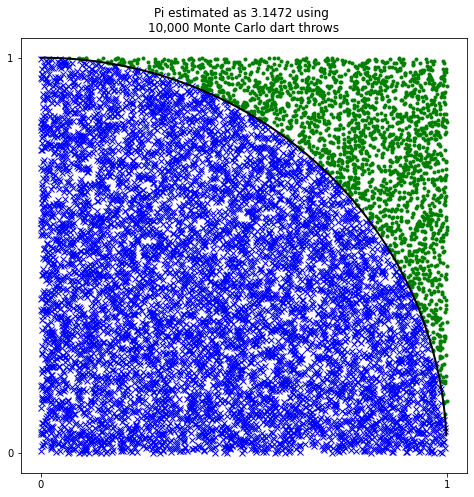

In [6]:
import numpy as np
import matplotlib.pyplot as plt


if __name__ == "__main__":
    np.random.seed(0)  # force repeatable plt
    nbr_items = int(1E4)
    xs = np.random.uniform(0, 1, nbr_items)
    ys = np.random.uniform(0, 1, nbr_items)
    estimate_inside_quarter_unit_circle = (xs * xs + ys * ys) <= 1
    nbr_trials_in_quarter_unit_circle = np.sum(estimate_inside_quarter_unit_circle)
    pi = (nbr_trials_in_quarter_unit_circle * 4) / nbr_items  # estimate for the full circle

    plt.figure(1, figsize=(8, 8))
    plt.clf()
    plt.plot(xs[estimate_inside_quarter_unit_circle], ys[estimate_inside_quarter_unit_circle], 'bx')
    plt.plot(xs[estimate_inside_quarter_unit_circle == False], ys[estimate_inside_quarter_unit_circle == False], 'g.')

    unit_circle_xs = np.arange(0, 1, 0.001)
    unit_circle_ys = np.sin(np.arccos(unit_circle_xs))
    plt.plot(unit_circle_xs, unit_circle_ys, linewidth=2, c="k")
    plt.xticks([0.0, 1.0])
    plt.yticks([0.0, 1.0])
    plt.title("Pi estimated as {} using \n{:,} Monte Carlo dart throws".format(pi, int(nbr_items)))
    plt.show()
#     plt.tight_layout()
#     plt.savefig("09_pi_plot_monte_carlo_example.png")


用蒙特卡罗方法估计$\pi$

在下面示例中请查看这个的循环版本. 我们将实现一个普通的Python版本和稍后的numpy版本，后面将使用线程和进程来并行化问题。

# 使用进程和线程估计 $\pi$

普通的Python实现更容易理解，因此我们先从这一点开始，在循环中使用float对象。我们将使用进程来并行化这个过程，以使用所有可用的CPU，并且随着使用更多CPU，我们将可视化机器的状态。

## 使用Python对象

Python实现很容易理解，但是它会带来开销，因为每个Python float对象都必须依次被管理、引用和同步。这种开销降低了运行时的速度，但它为我们赢得了思考的时间，因为实现很快就完成了。通过并行化这个版本，我们只需要很少的额外工作就可以获得额外的加速。

下面图显示了Python示例的三种实现：
- 不使用多处理（称为“串行”）——一个用于主进程中的循环
- 运用线程（threads）
- 使用进程（processes）

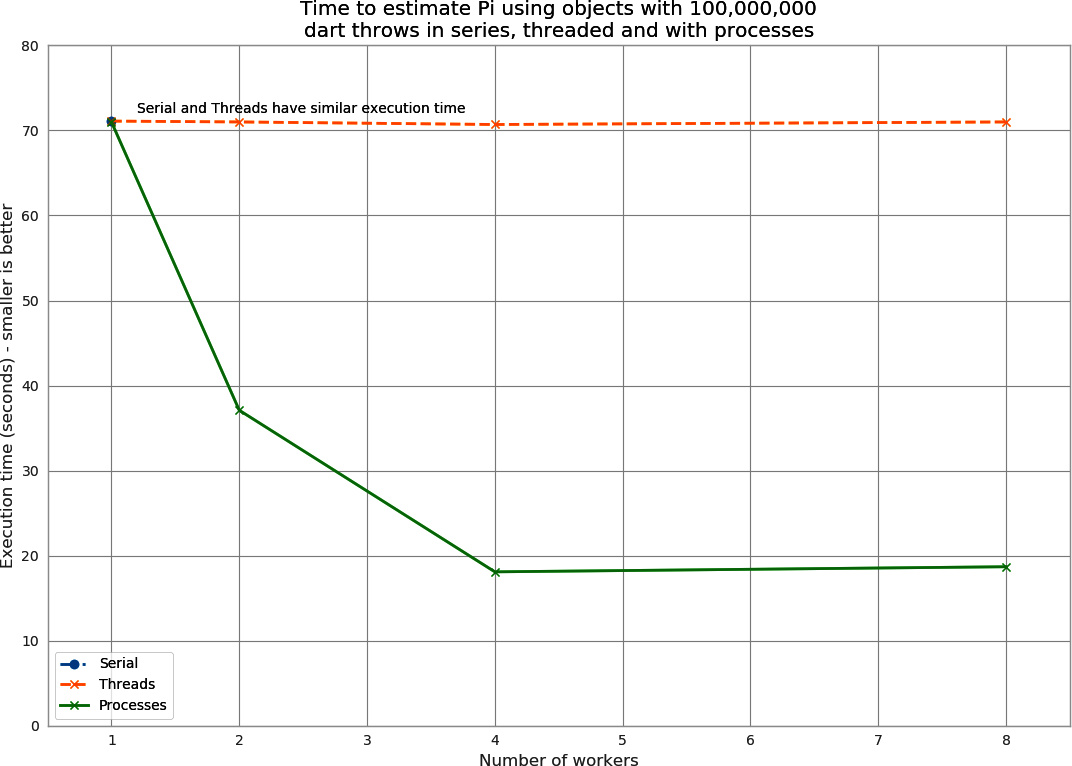

当我们使用多个线程或进程时，我们要求Python计算相同的dart抛出总数，并在工作线程之间平均分配工作。如果我们希望使用Python实现总共执行100000000次dart抛出，并且使用两个worker，那么我们将要求两个线程或两个进程为每个worker生成50000000次dart抛出。

使用一个线程大约需要71秒，使用更多线程时没有加速。通过使用两个或多个进程，我们可以缩短运行时间。不使用进程或线程（系列实现）的成本与使用一个进程运行的成本相同。

通过使用进程，当在笔记本电脑上使用两个或四个内核时，我们得到了线性加速。对于8个工作进程的情况，我们使用的是英特尔的超线程技术笔记本电脑只有4个物理内核，因此运行8个进程在加速方面几乎没有任何变化。

下面例子显示了 $\pi$ 估计器的Python版本。如果我们使用线程，则每条指令都由 GIL 绑定，因此尽管每个线程可以在单独的CPU上运行，但只有在没有其他线程运行时，它才会执行。进程版本不受此限制，因为每个分叉的进程都有一个作为单个线程运行的私有Python解释器没有GIL争用，因为没有共享对象。我们使用Python内置的随机数生成器，但请参阅“并行系统中的随机数”，以了解有关并行随机数序列危险性的一些说明。

在Python中使用循环估计 $\pi$:

In [7]:
def estimate_nbr_points_in_quarter_circle(nbr_estimates):
    """Monte Carlo estimate of the number of points in a
       quarter circle using pure Python"""
    print(f"Executing estimate_nbr_points_in_quarter_circle  \
            with {nbr_estimates:,} on pid {os.getpid()}")
    nbr_trials_in_quarter_unit_circle = 0
    for step in range(int(nbr_estimates)):
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        is_in_unit_circle = x * x + y * y <= 1.0
        nbr_trials_in_quarter_unit_circle += is_in_unit_circle

    return nbr_trials_in_quarter_unit_circle

请注意，我们在启动计时器之前先构建池。产生线程是相对即时的；产生过程涉及到一个分叉，这需要可测量的几分之一秒。我们忽略了这个开销，因为这个成本只占整个执行时间的一小部分。

In [ ]:
from multiprocessing import Pool
import time
nbr_samples_in_total = 1e8
nbr_parallel_blocks = 2
pool = Pool(processes=nbr_parallel_blocks)
nbr_samples_per_worker = nbr_samples_in_total / nbr_parallel_blocks
print("Making {:,} samples per {} worker".format(nbr_samples_per_worker,
                                                 nbr_parallel_blocks))
nbr_trials_per_process = [nbr_samples_per_worker] * nbr_parallel_blocks
t1 = time.time()
nbr_in_quarter_unit_circles = pool.map(estimate_nbr_points_in_quarter_circle,
                                       nbr_trials_per_process)
pi_estimate = sum(nbr_in_quarter_unit_circles) * 4 / float(nbr_samples_in_total)
print("Estimated pi", pi_estimate)
print("Delta:", time.time() - t1)

Making 50,000,000.0 samples per 2 worker


我们创建一个包含 nbr_estimates 数除以 worker 数量的列表。这个新参数将发送给每个worker。执行后，我们将收到相同数量的结果返回；我们将这些加起来，以估计单位圆中的道数。

我们从multiprocessing导入基于进程的 Pool。我们还可以使用multiprocessing.dummy导入池来获取线程版本。“虚拟”的名字是相当误导（不理解为什么它是这样命名的）；它只是线程模块周围的一个轻量级包装器，用于呈现与基于进程的池相同的接口。

In [ ]:
import random
import time
import argparse
import os

def estimate_nbr_points_in_quarter_circle(nbr_estimates):
    """Monte carlo estimate of the number of points in a quarter circle using pure Python"""
    print(f"Executing estimate_nbr_points_in_quarter_circle with {nbr_estimates:,} on pid {os.getpid()}")
    nbr_trials_in_quarter_unit_circle = 0
    for step in range(int(nbr_estimates)):
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        is_in_unit_circle = x * x + y * y <= 1.0
        nbr_trials_in_quarter_unit_circle += is_in_unit_circle

    return nbr_trials_in_quarter_unit_circle


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Project description')
    parser.add_argument('nbr_workers', type=int, help='Number of workers e.g. 1, 2, 4, 8')
    parser.add_argument('--nbr_samples_in_total', type=int, default=1e8, help='Number of samples in total e.g. 100000000')
    parser.add_argument('--processes', action="store_true", default=False, help='True if using Processes, absent (False) for Threads')

    args = parser.parse_args()
    if args.processes:
        print("Using Processes")
        from multiprocessing import Pool
    else:
        print("Using Threads")
        from multiprocessing.dummy import Pool

    nbr_samples_in_total = args.nbr_samples_in_total  # should be 1e8
    nbr_parallel_blocks = args.nbr_workers
    pool = Pool(processes=nbr_parallel_blocks)
    nbr_samples_per_worker = nbr_samples_in_total / nbr_parallel_blocks
    print("Making {:,} samples per {} worker".format(nbr_samples_per_worker, nbr_parallel_blocks))
    nbr_trials_per_process = [nbr_samples_per_worker] * nbr_parallel_blocks
    t1 = time.time()
    nbr_in_quarter_unit_circles = pool.map(estimate_nbr_points_in_quarter_circle, nbr_trials_per_process)
    pi_estimate = sum(nbr_in_quarter_unit_circles) * 4 / float(nbr_samples_in_total)
    print("Estimated pi", pi_estimate)
    print("Delta:", time.time() - t1)


下图描绘了笔记本电脑的四个物理内核及其四个相关超线程（每个超线程在物理内核中未使用的硅上运行）的平均CPU利用率。为这些图收集的数据包括第一个Python进程的启动时间和启动子进程的成本。CPU采样器记录笔记本电脑的整个状态，而不仅仅是这个任务使用的CPU时间。

请注意，以下图表是使用不同的计时方法创建的，其采样率比图中的慢，所以整个运行时间要长一点。

图中的执行行为在池中有一个进程（连同父进程）时，在创建池的最初几秒钟内会显示一些开销，然后在整个运行过程中CPU利用率始终接近100%。通过一个进程，我们可以有效地使用一个核心。

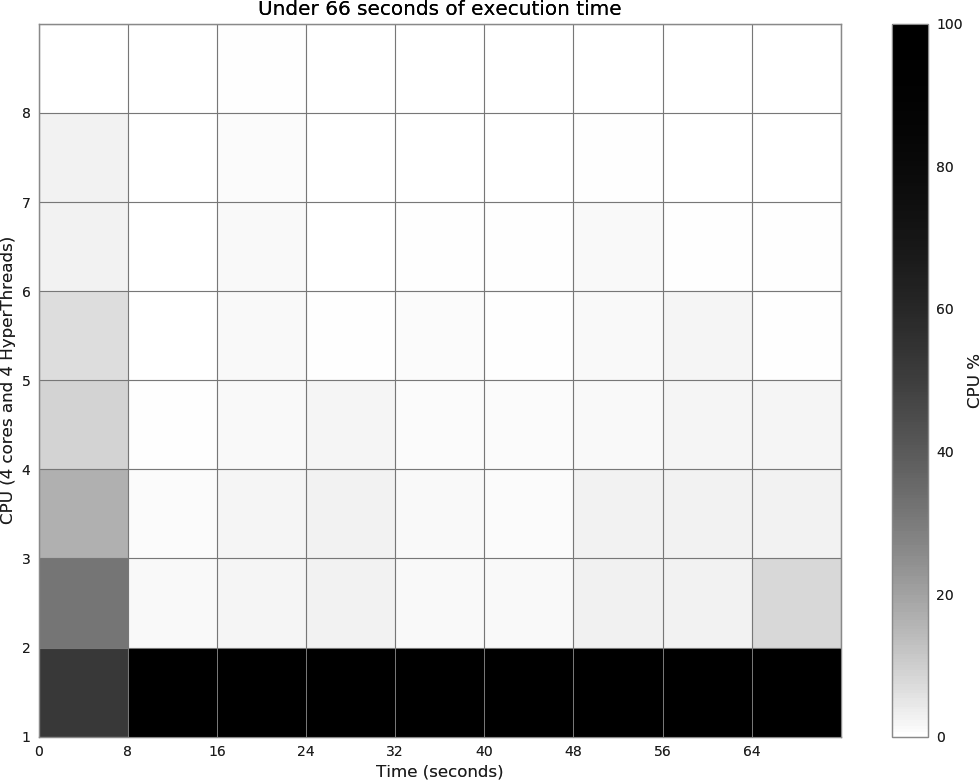

接下来我们将添加第二个进程，实际上是Pool（processs=2）。如下图所示，添加第二个进程大约将执行时间减半到37秒，两个CPU被完全占用。这是我们所能期望的最佳结果——我们已经有效地使用了所有新的计算资源，而且我们不会因为其他开销（如通信、磁盘分页或与希望使用相同CPU的竞争进程争用）而损失任何速度。

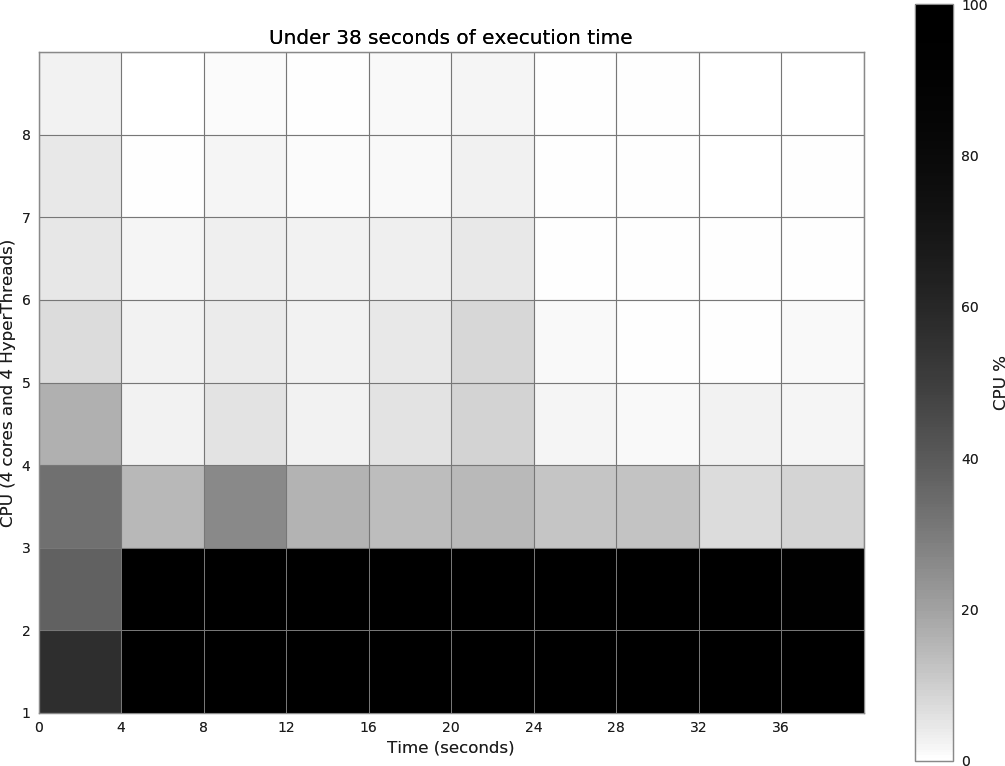

使用Python对象和两个进程估计$\pi$

下图显示了使用所有四个物理CPU时的结果现在我们正在使用此笔记本电脑的所有原始电源。执行时间大约是单进程版本的四分之一，为19秒。

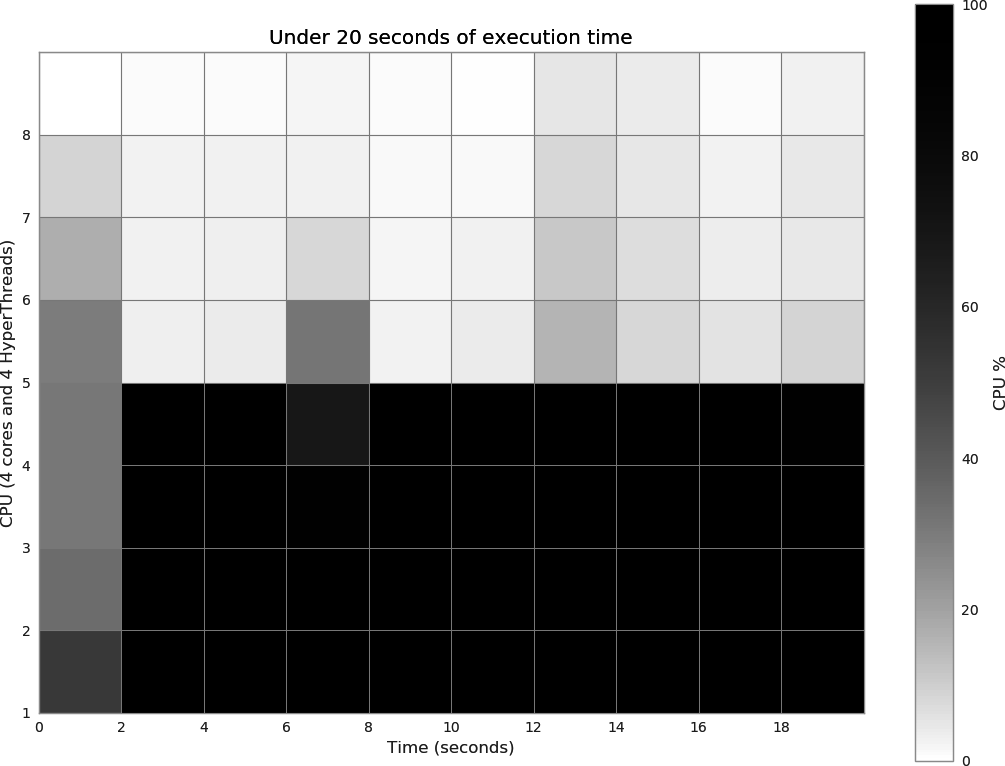

使用Python对象和四个进程估计 $\pi$

切换到8个进程，如下图所示，与四进程版本相比，我们只能实现一个微小的加速。这是因为四个超线程只能从CPU上的备用硅中挤出一点额外的处理能力，而这四个CPU已经得到了最大限度的利用。

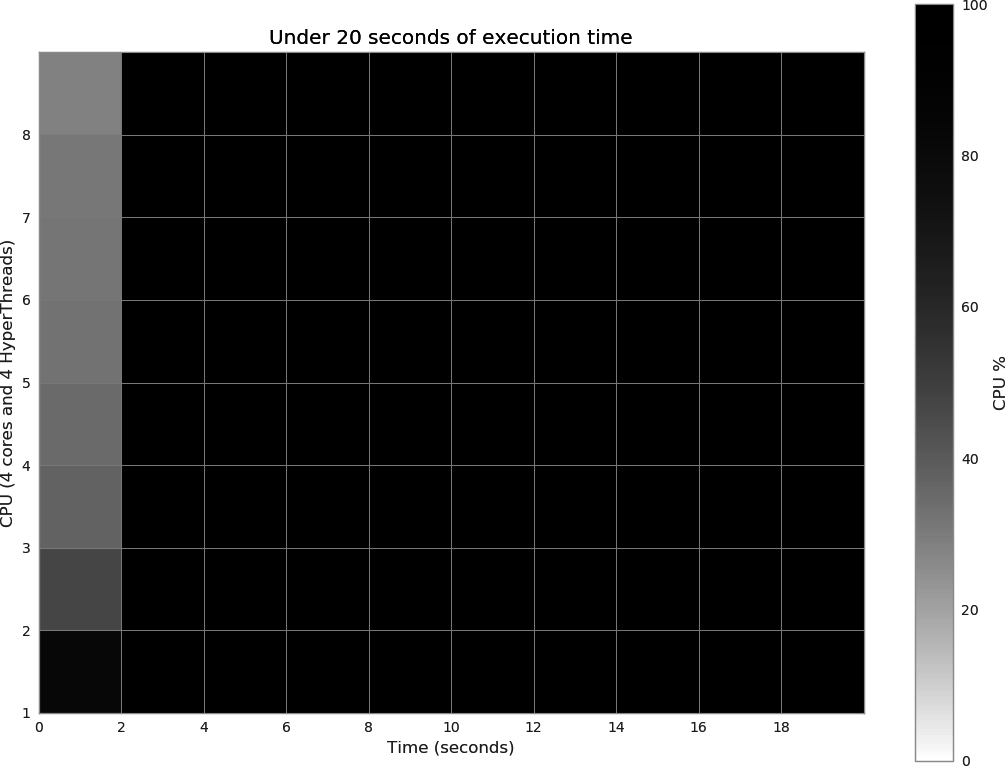

使用Python对象和八个进程估计$\pi$，几乎没有额外的增益

这些图表表明，我们在每一步都有效地使用了更多的可用CPU资源，而超线程资源是一个糟糕的加法。使用超线程时最大的问题是CPython使用了大量的RAM超线程对缓存不友好，因此每个芯片上的空闲资源利用率很低。我们将在下一节中看到，numpy更好地利用了这些资源。

现在我们将切换到在一个进程中使用线程，而不是在多个进程中使用线程。

下图显示了用线程代替进程。尽管使用了许多CPU，但它们各自分担的工作量很小。如果每个线程在没有GIL的情况下运行，那么我们将看到四个CPU上100%的CPU利用率。相反，每个CPU都被部分利用（因为GIL）。

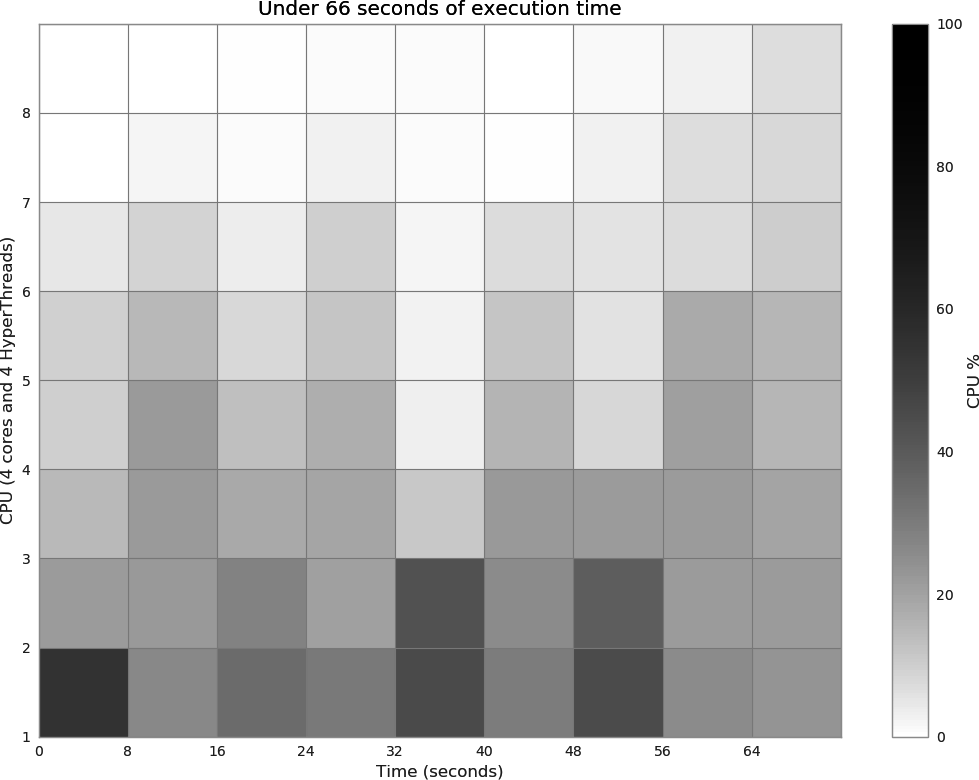

使用Python对象和四个线程估计 $\pi$

## 用Joblib替换多处理

Joblib是对多处理的一种改进，它支持轻量级流水线，重点是简单的并行计算和透明的基于磁盘的结果缓存。它专注于科学计算的NumPy数组。

- 使用纯Python，不管有没有NumPy，来处理一个可能令人尴尬的并行循环
- 调用没有副作用的昂贵函数，输出可以在会话之间缓存到磁盘
- 能够在进程之间共享NumPy数据，但不知道如何共享

Joblib构建在Loky库（本身是对Python的concurrent.futures的改进）的基础上，并使用cloudpickle来启用在交互作用域中定义的函数的pickle。这解决了内置多处理库遇到的几个常见问题。

对于并行计算，我们需要并行类和延迟装饰器。Parallel类设置了一个进程池，类似于我们在上一节中使用的多进程池。延迟修饰符包装我们的目标函数，这样就可以通过迭代器将其应用于实例化的并行对象。

语法读起来有点混乱. 调用记录在一条线上；这包括我们的目标函数 estimate_nbr_points_in_quarter_circle，以及范围内 sample_idx 的迭代器(delayed(...)(nbr_samples_per_worker) for sample_idx in range(nbr_parallel_blocks))。让我们把它分解一下。

用Joblib实现pi估计的并行化:

In [1]:
def estimate_nbr_points_in_quarter_circle(nbr_estimates):
    """Monte Carlo estimate of the number of points in a
       quarter circle using pure Python"""
    print(f"Executing estimate_nbr_points_in_quarter_circle  \
            with {nbr_estimates:,} on pid {os.getpid()}")
    nbr_trials_in_quarter_unit_circle = 0
    for step in range(int(nbr_estimates)):
        x = random.uniform(0, 1)
        y = random.uniform(0, 1)
        is_in_unit_circle = x * x + y * y <= 1.0
        nbr_trials_in_quarter_unit_circle += is_in_unit_circle

    return nbr_trials_in_quarter_unit_circle

In [3]:
import random
import os
import time
import argparse
from joblib import Parallel, delayed


if __name__ == "__main__":
    nbr_samples_in_total = int(1e8)
    nbr_parallel_blocks = 8

    nbr_samples_per_worker = int(nbr_samples_in_total / nbr_parallel_blocks)
    print("Making {:,} samples per {} worker".format(nbr_samples_per_worker, nbr_parallel_blocks))
    t1 = time.time()
    nbr_in_quarter_unit_circles = Parallel(n_jobs=nbr_parallel_blocks, verbose=1)(delayed(estimate_nbr_points_in_quarter_circle)(nbr_samples_per_worker) for sample_idx in range(nbr_parallel_blocks))
    pi_estimate = sum(nbr_in_quarter_unit_circles) * 4 / float(nbr_samples_in_total)
    print("Estimated pi", pi_estimate)
    print("Delta:", time.time() - t1)



Making 12,500,000 samples per 8 worker


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   13.3s remaining:   40.2s


Estimated pi 3.14148912
Delta: 13.734785795211792


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   13.6s finished


Paralle 是一个类；我们可以设置参数，例如 n_jobs ，以指示将运行多少进程，以及可选参数，例如verbose，用于调试信息。其他参数可以设置超时、在线程或进程之间更改、更改后端（这有助于加快某些边缘情况）以及配置内存映射。

Parallel有一个可调用的方法 `__call__`，它接受iterable。我们提供以下圆括号(... for sample_idx in range(...))。可调用函数迭代每个延迟delayed(estimate_nbr_points_in_quarter_circle)函数，将这些函数的执行批处理到它们的参数（在本例中，nbr_samples_per_worker）。发现一步一步地建立一个并行化调用是很有帮助的，从一个没有参数的函数开始，根据需要建立参数。这使得诊断失误更加容易。

nbr_in_quarter_unit_circles将是一个列表，其中包含与以前一样的每次通话的阳性病例数。例子 9-4显示八个并行块的控制台输出；每个进程ID（PID）都是新创建的，并且在输出的末尾的进度条中打印一个摘要。总共需要13.7秒，与我们在上一节中创建自己的池时所用的时间相同。

##### 函数调用结果的智能缓存

Joblib中一个有用的特性是内存缓存；这是一个装饰器，它根据磁盘缓存的输入参数缓存函数结果。这个缓存在Python会话之间持久存在，因此如果您关闭计算机，然后在第二天运行相同的代码，那么将使用缓存的结果。

对于我们的pi估计，这是一个小问题。我们不传递唯一的参数estimate_nbr_points_in_quarter_circle；对于我们传入的每个调用，nbr_estimates 是相同的，因此调用签名是相同的，但我们追求的是不同的结果。

在这种情况下，一旦第一个调用完成（大约需要19秒），任何具有相同参数的后续调用都将获得缓存结果。这意味着，如果我们第二次重新运行代码，它会立即完成，但它只使用八个样本结果中的一个作为每个调用的结果，这显然破坏了我们的蒙特卡罗采样！如果最后一个要完成的进程导致四分之一圆中有9815738个点，则函数调用的缓存将始终回答此问题。重复调用八次将产生[9815738、9815738、9815738、9815738、9815738、9815738、9815738、9815738、9815738]而不是八个唯一的估计。

示例中的解决方案将传入第二个参数idx，它的值介于0和nbr_parallel_blocks-之间。这种独特的参数组合将使缓存存储每个正计数，这样在第二次运行时，我们得到与第一次运行相同的结果，但不需要等待。

这是使用Memory配置，内存使用一个文件夹来保存函数结果。这种持久性在Python会话之间保持；如果更改正在调用的函数，或者清空缓存文件夹中的文件，则会刷新该函数。

请注意，此刷新仅适用于已修饰函数的更改（在本例中，使用estimate_nbr_points_in_quarter_circle_with_idx），而不适用于从该函数内部调用的任何子函数。

##### 使用Joblib缓存结果

In [1]:
%cd ./pi_estimation/pi_lists_parallel

D:\Jupyter\课程教案\03《并行计算与GPU编程》\第02章 Python高性能编程\3 Python并行计算\2 进程和线程\pi_estimation\pi_lists_parallel


Joblib用一个简单的（如果有点难读的话）接口包装了许多多处理功能,使用Joblib来支持多处理。

## 并行系统中的随机数

生成好的随机数序列是一个困难的问题，如果你自己尝试的话，很容易出错。在并行过程中快速获得一个好的序列就更难了,突然之间你不得不担心在并行过程中是否会得到重复的或相关的序列。

我们在示例中使用了Python内置的随机数生成器，我们将在下面示例中使用numpy随机数生成器。在这两种情况下，随机数生成器都是在分叉过程中播种的。对于Python random示例，如果在fork过程中看到random在名称空间中，它将强制调用为每个新进程中的生成器播种，则播种由多进程在内部处理。

如果关心并行过程中使用的随机数的质量，建议研究这个主题。也许numpy和Python随机数生成器已经足够好了，但是如果重要的结果取决于随机序列的质量（例如，对于医疗或金融系统），那么必须仔细阅读这方面的内容。

在python3中，使用了Mersenne Twister算法，因为它有很长的周期，所以序列不会长时间重复。它是经过严格测试的，因为它在其他语言中使用，而且是线程安全的。它可能不适合用于加密目的。

## 使用numpy

在本节中，我们将切换到使用numpy。我们的掷镖问题非常适合于numpy矢量化操作，我们生成的相同估计比前面的Python示例快25倍。

numpy在解决相同问题时比纯Python更快的主要原因是，numpy在RAM的连续块中以非常低的级别创建和操作相同的对象类型，而不是创建许多更高级别的Python对象，每个对象都需要单独的管理和寻址。

由于numpy对缓存友好得多，因此在使用四个超线程时，我们还将获得一个小的速度提升。我们在纯Python版本中没有得到这一点，因为大型Python对象不能有效地使用缓存。

在图中，我们看到三种情况：
- 不使用多处理（称为“串行”）
- 运用线程
- 使用进程

串行和单工作线程版本以相同的速度执行，使用numpy线程没有开销（而且只有一个工作线程，也没有收益）。

当使用多个进程时，我们看到每增加一个CPU的典型的100%利用率。结果反映了所示的绘图，但是使用numpy的代码要快得多。

有趣的是，线程版本运行得更快，线程越多。正如在scipywiki上所讨论的，通过在GIL之外工作，numpy可以在线程周围实现某种程度的额外加速。

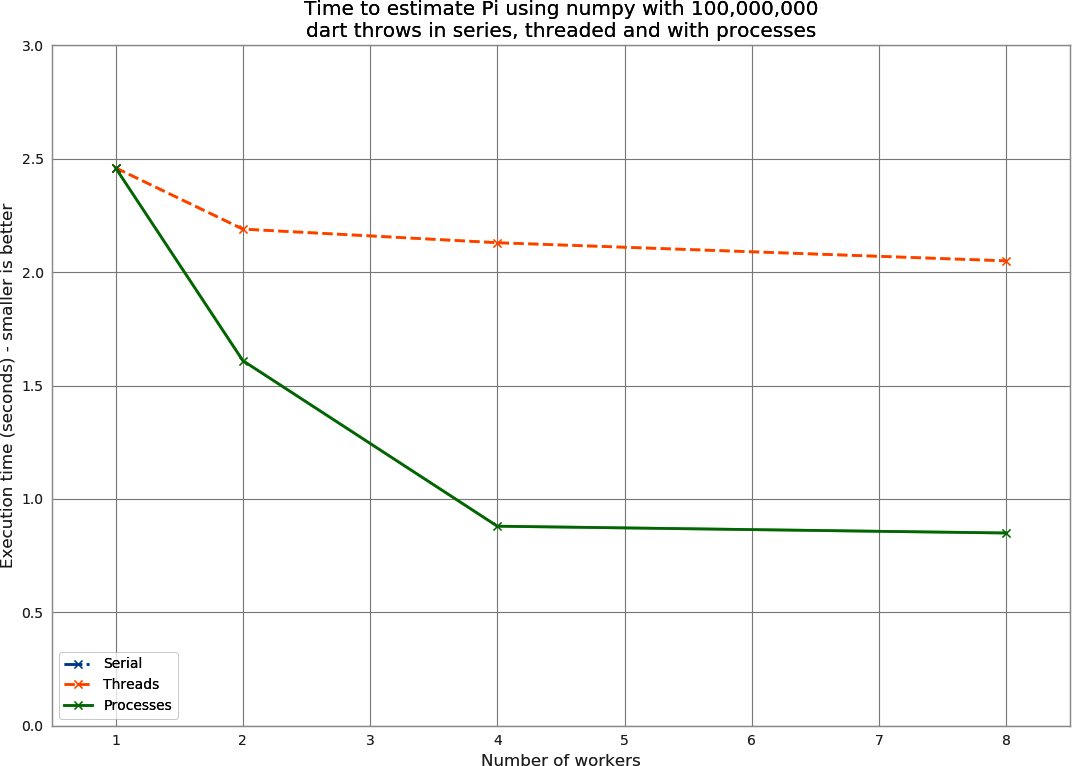

串联工作、使用线程和使用numpy的进程

D:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()
D:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


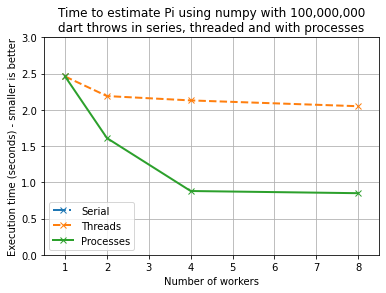

In [6]:
"""Graph execution time for serial, threaded and processes forms of Pi estimation with numpy"""
import numpy as np
import matplotlib.pyplot as plt

# timings generated using
# pi_numpy_serial_blocks.py
# (serial.py - same as serial blocks but for 1 large array only)
# pi_numpy_parallel_worker.py
speeds = np.array([[2.46],
                   [2.46, 2.19, 2.13, 2.05],
                   [2.46, 1.61, 0.88, 0.85]])

nbr_cores = np.array([[1],
                      [1, 2, 4, 8],
                      [1, 2, 4, 8]])

labels = np.array(["Serial", "Threads", "Processes"])

plt.figure(1)
plt.clf()
markers = ['-.x', '--x', '-x']
for nc, sp, label, mk in zip(nbr_cores, speeds, labels, markers):
    plt.plot(nc, sp, mk, label=label, linewidth=2)
plt.legend(loc="lower left", framealpha=0.8)
plt.ylim(0, 3)
plt.xlim(0.5, 8.5)
plt.ylabel("Execution time (seconds) - smaller is better")
plt.xlabel("Number of workers")
plt.title("Time to estimate Pi using numpy with 100,000,000\ndart throws in series, threaded and with processes")
plt.grid()
plt.show()
# plt.tight_layout()
# plt.savefig("09_pi_numpy_graph_speed_tests_threaded_processes.png")


使用进程给了我们一个可预测的加速，就像在纯Python示例中一样。第二个CPU使速度加倍，使用四个CPU使速度加倍。

下面例子显示了代码的矢量化形式。请注意，在调用此函数时，随机数生成器是种子。对于线程版本，这是没有必要的，因为每个线程共享相同的随机数生成器，并且它们以串行方式访问它。对于流程版本，由于每个新流程都是一个fork，所有fork版本将共享相同的状态。这意味着每个随机数调用将返回相同的序列！

用numpy估计$\pi$

简短的代码分析表明，当使用多个线程执行时，对random的调用在这台机器上运行得稍慢，对 (xs * xs + ys * ys) <= 1 的调用并行性很好。对随机数生成器的调用是GIL绑定的，因为内部状态变量是Python对象。

理解这一点的过程是基本但可靠的：
1. 注释掉所有numpy行，并使用串行版本在没有线程的情况下运行。运行几次并使用`__main__` 中的`time.time（）` 记录执行时间。
2. 添加一行（我们首先添加`xs = np.random.uniform(...)`，然后运行几次，再次记录完成时间。
3. 添加下一行（现在添加ys=…），再次运行，并记录完成时间。
4. 重复，包括`nbr_trials_in_quarter_unit_circle = np.sum(...)`行。
5. 再次重复此过程，但这次使用四个线程。逐行重复。
6. 比较无线程和四个线程在每个步骤的运行时差异。

因为我们并行运行代码，所以很难使用诸如 line_profiler 或 cProfile 之类的工具。记录原始运行时并观察不同配置下的行为差异需要耐心，但可以提供可靠的证据来得出结论。